<a href="https://colab.research.google.com/github/Le-Triumvirat/CADS-Internship/blob/main/Anomaly_detection_in_financial_services_using_knowledge_graphs_and_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Installing DGL and DGL-KE</h1>

> pip install dgl

> pip install dglke

# Rough work 
>    Our cave to brainstorm and invent

In [1]:
import dgl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# unique nodes are 34 and edge connections are 156 (might include either directed or undirected)
def build_karate_club_graph():
    # source node
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    # destination node
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # concatenating source and destination to form connections represented as directed, as DGL by default doesn't include directed.
    u = np.concatenate([src,dst])
    v = np.concatenate([dst,src])
    return dgl.graph((u,v))

Using backend: pytorch


In [2]:
g = build_karate_club_graph()
# g.ndata['features'] = torch.zeros(34,1)
# print(g)
# print(nx)
nx_g = g.to_networkx().to_undirected()
# print(type(nx_g))
'''A layout function for returning coordinates of edges'''
pos = nx.kamada_kawai_layout(nx_g)
# print(pos)

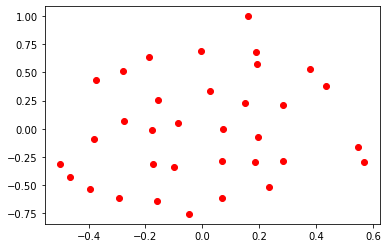

In [4]:
'''nothing interesting here'''
for i in range(34):
  plt.scatter(pos[i][0],pos[i][1],color='red')

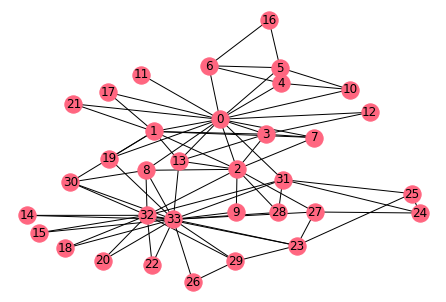

In [3]:
'''The real deal'''
nx.draw(nx_g, pos, with_labels=True, node_color=[[1,.4,.5]])

In [6]:
'''Creation of GCN starts'''

import torch
import torch.nn as nn
import torch.nn.functional as F

# a=torch.tensor([[1,2,3],[4,5,6]])
embed = nn.Embedding(34,5)
# print(embed(a))
# print(type(embed))
# print(embed.weight)
g.ndata['feat'] = embed.weight
# g.ndata['feat'][[0,1]]

In [7]:
from dgl.nn.pytorch import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        # super(GCN, self).__init__()
        super().__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h
net = GCN(5, 5, 2)

In [8]:
inputs = embed.weight
# print(inputs.size())
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [9]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(g, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6507
Epoch 1 | Loss: 0.6288
Epoch 2 | Loss: 0.6068
Epoch 3 | Loss: 0.5842
Epoch 4 | Loss: 0.5616
Epoch 5 | Loss: 0.5388
Epoch 6 | Loss: 0.5154
Epoch 7 | Loss: 0.4912
Epoch 8 | Loss: 0.4669
Epoch 9 | Loss: 0.4428
Epoch 10 | Loss: 0.4183
Epoch 11 | Loss: 0.3929
Epoch 12 | Loss: 0.3672
Epoch 13 | Loss: 0.3412
Epoch 14 | Loss: 0.3158
Epoch 15 | Loss: 0.2914
Epoch 16 | Loss: 0.2677
Epoch 17 | Loss: 0.2444
Epoch 18 | Loss: 0.2220
Epoch 19 | Loss: 0.2005
Epoch 20 | Loss: 0.1796
Epoch 21 | Loss: 0.1602
Epoch 22 | Loss: 0.1421
Epoch 23 | Loss: 0.1252
Epoch 24 | Loss: 0.1099
Epoch 25 | Loss: 0.0960
Epoch 26 | Loss: 0.0836
Epoch 27 | Loss: 0.0726
Epoch 28 | Loss: 0.0629
Epoch 29 | Loss: 0.0544
Epoch 30 | Loss: 0.0470
Epoch 31 | Loss: 0.0407
Epoch 32 | Loss: 0.0352
Epoch 33 | Loss: 0.0306
Epoch 34 | Loss: 0.0266
Epoch 35 | Loss: 0.0232
Epoch 36 | Loss: 0.0203
Epoch 37 | Loss: 0.0178
Epoch 38 | Loss: 0.0157
Epoch 39 | Loss: 0.0139
Epoch 40 | Loss: 0.0123
Epoch 41 | Loss: 0.0110
Ep

In [10]:
print(f'Total epochs : {len(all_logits)}')
print(f'Size of each graph in an epoch : {all_logits[0].size()}')

# a=[1,2,3,4.5]
# max(a)

Total epochs : 50
Size of each graph in an epoch : torch.Size([34, 2])


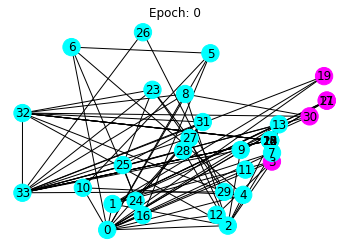

In [42]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

def draw(i):
    '''Unique colors for node with feature 0 and 1'''
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    '''Feature embeddings are taken as coordinates or vice-versa. Its bidirectional, you know'''
    pos = {}
    '''Colors for every node is stored in a list for passing argument to networkx'''
    colors = []
    '''For every epoch(i), the feature embeddings are taken for the respective node.'''
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax() #argmax() returns the position of the max value present in the list. Either 0 or 1 in this case.
        colors.append(cls1color if cls else cls2color)
    ax.cla() #clears the axes
    ax.axis('off') #axes are set to off
    ax.set_title('Epoch: %d' % i)
    
#     nx.draw_networkx(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)
    nx.draw(nx_g.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)

# fig = plt.figure(dpi=100)
fig = plt.figure() # by default, dpi is 100
fig.clf() # to clear the figure, just as a best practice
ax = fig.subplots() # single axis
draw(0)  # draw the prediction of the first epoch
# plt.close()

In [44]:
'''Not working.'''
ani = animation.FuncAnimation(fig, func=draw, frames=np.arange(0,len(all_logits)), interval=200)
plt.show()

<h1>DGL with CoraDataset</h1>

In [45]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [49]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [61]:
g = dataset[0]
print('Node features')
print(f"Feature space dimension : {g.ndata['feat'].size()}")
print(g.ndata)
print('Edge features')
print(g.edata)

Node features
Feature space dimension : torch.Size([2708, 1433])
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}
Edge features
{}


In [65]:
from dgl.nn import GraphConv

class GCN_cora(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super().__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN_cora(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [102]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        '''CrossEntropyLoss is used as it is a categorical set.'''
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 10 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.945, val acc: 0.154 (best 0.154), test acc: 0.168 (best 0.168)
In epoch 10, loss: 1.787, val acc: 0.482 (best 0.518), test acc: 0.473 (best 0.533)
In epoch 20, loss: 1.545, val acc: 0.576 (best 0.576), test acc: 0.582 (best 0.582)
In epoch 30, loss: 1.244, val acc: 0.628 (best 0.628), test acc: 0.639 (best 0.639)
In epoch 40, loss: 0.925, val acc: 0.656 (best 0.658), test acc: 0.670 (best 0.663)
In epoch 50, loss: 0.646, val acc: 0.708 (best 0.708), test acc: 0.715 (best 0.715)
In epoch 60, loss: 0.435, val acc: 0.722 (best 0.722), test acc: 0.733 (best 0.733)
In epoch 70, loss: 0.291, val acc: 0.742 (best 0.742), test acc: 0.755 (best 0.755)
In epoch 80, loss: 0.197, val acc: 0.756 (best 0.756), test acc: 0.764 (best 0.764)
In epoch 90, loss: 0.138, val acc: 0.760 (best 0.762), test acc: 0.755 (best 0.755)


In [77]:
damn=model.parameters()
i=0
while(i<4):
    print(next(damn).size())
    i+=1

torch.Size([1433, 16])
torch.Size([16])
torch.Size([16, 7])
torch.Size([7])


In [101]:
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

logits = model(g, features)

# Compute prediction
pred = logits.argmax(1)
print(pred)
print(pred.size())
print(logits.size())
print(logits[0].argmax(0))

tensor([3, 4, 4,  ..., 3, 3, 3])
torch.Size([2708])
torch.Size([2708, 7])
tensor(3)


<h1>Knowledge graph</h1>
<p>Headline files:</p>
<ol>
    CNN
    <li>boeing.csv</li>
    <li>google.csv</li>
    <li>walmart.csv</li>
    <br>Reuters
    <li>apple.csv</li>
    <li>microsoft.csv</li>
    <li>samsung.csv</li>
</ol>

Headlines dataset are present in the directory "headlines"
To install pandas, perform the following command in the terminal

> **pip install pandas**


In [10]:
import pandas as pd

directory = './headlines/'
headline_filenames = ['boeing.csv','google.csv','walmart.csv','apple.csv','microsoft.csv','samsung.csv']
stock_filenames = {'apple':'AAPL.csv','boeing':'BA.csv','google':'GOOG.csv','microsoft':'MSFT.csv','samsung':'SSNLF.csv','walmart':'WMT.csv'}
companies = ['boeing','google','walmart','apple','microsoft','samsung']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# headline_filenames[0][:-4]

In [49]:
for i in filenames:
    a=pd.read_csv(directory+i)
    print(a.head(2))

        Date                                              Title
0  24-Feb-17  Trump rally: CEOs of Dow companies make $400 m...
1  24-Feb-17  Has my pilot had too much to drink? It depends...
        Date                                              Title
0  27-Feb-17  Historic Oscar victories for ESPN, Netflix and...
1  25-Feb-17  Apple, Microsoft, PayPal join legal fight for ...
        Date                                              Title
0  27-Feb-17  Ellen DeGeneres and Walmart give these student...
1  24-Feb-17  Trump rally: CEOs of Dow companies make $400 m...
              Date                                              Title
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...
                 Date                                              Title
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 

Since Apple and Microsoft don't have headers in their csv files, the following code includes them. Just execute it once.

In [27]:
print('Original dataset of apple.csv')
apple=pd.read_csv(directory+'apple.csv')
print(apple.head(2))

Original dataset of apple.csv
   2011/10/17 0:00       Tech wrap: Apples Siri spurs iPhone 4S sales
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...


In [31]:
print('Updated dataset of apple.csv')
apple.to_csv(directory+'apple.csv',header=["Date","Title"],index=False)
apple=pd.read_csv(directory+'apple.csv')
print(apple.head(2))

Updated dataset of apple.csv
              Date                                              Title
0  2011/10/18 0:00                 Apple iPhone 4S: Believe the hype?
1  2011/10/18 0:00  Tech wrap: Apple misses, Intel beats quarterly...


In [32]:
print('Original dataset of microsoft.csv')
microsoft=pd.read_csv(directory+'microsoft.csv')
print(microsoft.head(2))

Original dataset of microsoft.csv
   2011-10-20 0:00:00       Tech wrap: Basic phones lift Nokia to profit
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 m...


In [33]:
print('Updated dataset of microsoft.csv')
microsoft.to_csv(directory+'microsoft.csv',header=["Date","Title"],index=False)
microsoft=pd.read_csv(directory+'microsoft.csv')
print(microsoft.head(2))

Updated dataset of microsoft.csv
                 Date                                              Title
0  2011-10-26 0:00:00  Tech wrap: RIM delays tablet update, Nokia unv...
1  2011-11-01 0:00:00  Tech wrap: Yahoo finds interclick, pays $270 m...


<h3>Changing all the date category's format to yyyy/m/d and headlines to smallercase</h3>
1. Google <br>
2. Boeing <br>
3. Walmart <br>
4. Samsung <br>
5. Microsoft

In [24]:
'''
For Google, Boeing and Walmart
'''
def datePreProcess(company):
    df=pd.read_csv('./headlines/'+company+'.csv')
    df_len = len(df.index) # no of rows
    if(company in ['google','boeing','walmart']):
        for i in range(df_len):
            temp = df['Date'][i].split('-')
            temp[2] = '20'+temp[2]
            df['Date'][i] = temp[2]+'/'+str(months.index(temp[1])+1)+'/'+temp[0]
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
        
    if(company=='samsung'):
        for i in range(df_len):
            temp = df['Date'][i].split('-')
            if(temp[2][0]=='0'): # for day
                temp[2]=temp[2][-1]
            if(temp[1][0]=='0'): # for month
                temp[1]=temp[1][-1]
            df['Date'][i] = '/'.join(temp)
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
        
    if(company=='microsoft'):
        for i in range(df_len):
            temp = df['Date'][i][:-8].split('-')
            if(temp[2][0]=='0'):
                temp[2]=temp[2][-1]
            if(temp[1][0]=='0'): # for month
                temp[1]=temp[1][-1]
            df['Date'][i] = '/'.join(temp)
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
    
    if(company=='apple'):
        for i in range(df_len):
            df['Date'][i] = df['Date'][i][:-5]
            df['Title'][i] = df['Title'][i].lower()
        df.to_csv('./headlines/Pre-processed/'+company+'.csv',header=["Date","Title"],index=False)
    print(f'Successfully converted headlines to lowercase and updated the date format of {company}')

In [55]:
'''
Google headline date preprocessing
'''
datePreProcess('google')

Successfully converted headlines to lowercase and updated the date format of google


In [56]:
'''
Boeing headline date preprocessing
'''
datePreProcess('boeing')

Successfully converted headlines to lowercase and updated the date format of boeing


In [57]:
'''
Walmart headline date preprocessing
'''
datePreProcess('walmart')

Successfully converted headlines to lowercase and updated the date format of walmart


In [26]:
'''
Samsung headline date preprocessing
'''
datePreProcess('samsung')

Successfully converted headlines to lowercase and updated the date format of samsung


In [25]:
'''
Microsoft headline date preprocessing
'''
datePreProcess('microsoft')

Successfully converted headlines to lowercase and updated the date format of microsoft


In [60]:
'''
Apple headline date preprocessing
'''
datePreProcess('apple')

Successfully converted headlines to lowercase and updated the date format of apple


In [186]:
import pandas as pd
import dgl
import numpy as np
import networkx as nx

G = nx.Graph()

In [98]:
# colors=[]
# company_index=0
# for file in headline_filenames:
#     company_name = companies[company_index]
#     comp_news = pd.read_csv('./headlines/Pre-processed/'+file)
#     length = len(comp_news.index)
#     for index in range(length):
#         news = comp_news['Title'][index]
#         G.add_edges_from([(company_name,news)])
#         for comp in companies:
#             if comp in news:
#                 G.add_edges_from([(comp,news)])
#             else:
#                 continue
# #     print(length)
# nx.draw(G,with_labels=True)

KeyboardInterrupt: 

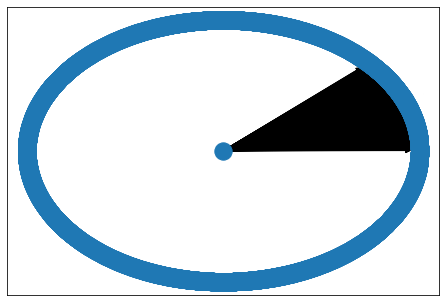

In [86]:
'''
Google KG complete
'''
Google_G = nx.Graph()
Google_G.add_node('Google')
Google = pd.read_csv('./headlines/Pre-processed/google.csv')
length_google = len(Google.index)

for i in range(length_google):
    Google_G.add_edges_from([('Google',Google['Title'][i])])
pos = nx.kamada_kawai_layout(Google_G)
nx.draw(Google_G,pos,with_labels=False)
# 1,7,2,3,

In [235]:
'''
Google KG minimal
'''
Google_G_min = nx.DiGraph()
Google_G_min.add_node('Google')
Google = pd.read_csv('./headlines/Pre-processed/google.csv')
Google_stock = pd.read_csv('./Stock Price/GOOG.csv')

# length_google = len(Google.index)
colors=['red']
for i in range(10):
#     stock_value = str(Google_stock.loc[Google_stock['Date']==Google['Date'][i]]['Close'])
    stock_value = Google_stock[Google_stock.eq(Google['Date'][i]).any(1)].to_numpy()[0][4]
#     print(stock_value if stock_value else print('no'))
    print(stock_value)
    
#     Google_G_min.add_edge('Google',Google['Title'][i])
#     Google_G_min.add_edge(Google['Title'][i],Google['Date'][i])
#     Google_G_min.add_edge(Google['Date'][i],'Google')
    
#     Google_G_min.add_edge(Google['Date'][i],stock_value)

# pos = nx.kamada_kawai_layout(Google_G_min)
pos = nx.random_layout(Google_G_min,center=None,dim=2)
# nx.draw(Google_G_min,pos,with_labels=True,node_color='orange')
nx.draw(Google_G_min,pos,with_labels=True,node_color='orange')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [197]:
stock_value = Google_stock.loc[Google_stock['Date']==Google['Date'][4]]['Close'].iloc[0]
stock_value
type(stock_value)

# 2017/2/23
Google_stock['Date']=='2017/2/23'

TypeError: index() takes at least 1 argument (0 given)

831.330017

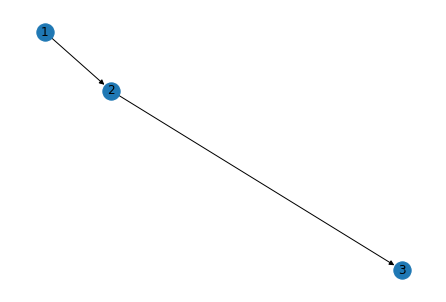

In [234]:
# GG = nx.lollipop_graph(4, 10)
GG = nx.DiGraph()
GG.add_edges_from([(1,2,{'close':'yep'})])
GG.add_edge(2,3)
pos = nx.random_layout(GG,center=None,dim=2)
nx.draw(GG,pos,with_labels=True)

a=Google_stock[Google_stock.eq('2017/2/23').any(1)].to_numpy()[0][4]
# b=a.to_numpy()
# b[0][4]
a
# print(a['Close'].value())

In [1]:
'''
KDJ  |  W%R  |  RSI
'''
import pandas as pd
goog = pd.read_csv('Stock Price\GOOG.csv')
print(f"KDJ (Min and Max) {goog['KDJ'].min()}\t {goog['KDJ'].max()}")
print(f"W%R (Min and Max) {goog['W%R'].min()}\t {goog['W%R'].max()}")
print(f"RSI (Min and Max) {goog['RSI'].min()}\t {goog['RSI'].max()}")
row_count = len(goog)
'''
Labels
0 - overbought > 0.8 (sell)
1 - oversold < 0.2 (buy)
2 - nil trend [0.2,0.8]
Note : Only AAPL has a column called as label
'''
# goog['KDJ'].sum()/len(goog['KDJ'].index)
# goog['KDJ'].max()
print('')

KDJ (Min and Max) 0.0	 1.0
W%R (Min and Max) -1.0	 0.0
RSI (Min and Max) -92.080017	 41.369995



<h4>KDJ | W%R</h4>
If it is between 20 and 80 the market is neutral, if it is above 80 it is bullish/overbought and if it is below 20 it is bearish/oversold. If it is below 0 or above 100 it is very bearish or very bullish, but also very-oversold and very-overbought.

Overbought --> overvalued that its intrinsic(bullish)<br>
Oversold --> undervalued that its intrinsic(bearish)

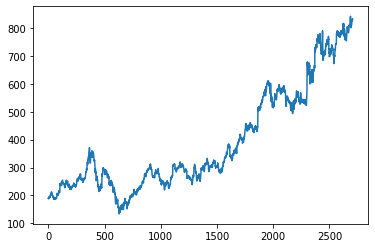

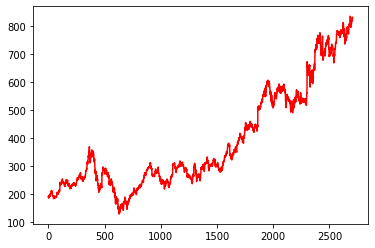

In [2]:
import matplotlib.pyplot as plt

plt.plot(goog['High'])
plt.show()
plt.plot(goog['Close'],color='red')
plt.show()

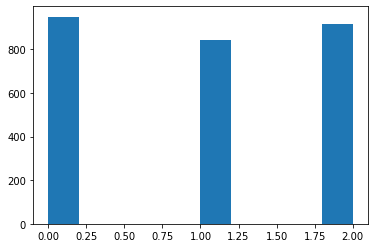

In [3]:
label=[]
for i in range(row_count):
    if(goog['KDJ'][i] < 0.2):
        label.append(1)
    elif(goog['KDJ'][i] > 0.8):
        label.append(0)
    else:
        status = ((goog['Close'][i]-goog['Open'][i])/goog['Open'][i])*100
        if(status < -0.66):
            label.append(0)
        elif(status > 0.66):
            label.append(1)
        else:
            label.append(2)
# print(label)
plt.hist(label)
plt.show()

In [4]:
print(label.count(0))
print(label.count(1))
print(label.count(2))

950
841
916


x<20...80<x
$100
(+$70)
$30
((closing-opening)/(opening))*100
<-0.75 sell
>0.75 buy

In [7]:
goog['Label']=label
goog

,Date,Open,High,Low,Close,Volume,KDJ,W%R,RSI,Label
0,2006/5/25,188.315186,190.262527,184.952072,190.257553,16495700,0.999063,-0.000937,0.000000,0
1,2006/5/26,191.032516,191.693222,188.787125,189.442856,7381600,0.225640,-0.774360,1.814697,0
2,2006/5/30,187.917770,189.268982,184.524841,184.768265,8688100,0.051310,-0.948690,5.674591,1
3,2006/5/31,185.692245,187.902878,182.204926,184.708649,16066300,0.439408,-0.560592,1.059616,2
4,2006/6/1,185.563095,190.257553,184.599365,190.073761,12637600,0.967518,-0.032482,-4.365112,0
...,...,...,...,...,...,...,...,...,...,...
2702,2017/2/17,823.020020,828.070007,821.655029,828.070007,1611000,1.000000,0.000000,-2.910034,0
2703,2017/2/21,828.659973,833.450012,828.349976,831.659973,1262300,0.649014,-0.350986,-2.589966,2
2704,2017/2/22,828.659973,833.250000,828.640015,830.760010,982900,0.459870,-0.540130,1.899963,2
2705,2017/2/23,830.119995,832.460022,822.880005,831.330017,1472800,0.882046,-0.117954,0.429993,0


In [33]:
'''
TF-IDF trial
'''
import pandas as pd
# from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

googH = pd.read_csv('./headlines/Pre-processed/google.csv')
type(googH['Title'])
headlines_list=googH['Title'].values.tolist()
headlines_list[0]

'historic oscar victories for espn, netflix and amazon'

In [40]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(headlines_list)

df = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
df
[0:{'word':'value'}]
# df.to_csv('./TFIDF'+'.csv',header=["TF-IDF"],index=True)

,TF-IDF
explosions,0.439147
boston,0.419091
points,0.359538
200,0.350520
falls,0.336290
...,...
fair,0.000000
failure,0.000000
fails,0.000000
failing,0.000000


In [29]:
df.head(8)

,TF-IDF
espn,0.455038
victories,0.455038
oscar,0.434256
historic,0.434256
netflix,0.279034
amazon,0.257704
and,0.193651
for,0.164171
